In [1]:
pip install xgboost prophet pickle dtw-python

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import dtw-python
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from prophet import Prophet

C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data and minor EDA

We load the data and set the index to be the DateTime column of the dataset.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

df = pd.read_csv("../data/electricityConsumptionAndProductioction.csv")

# set the DateTime as the index
df = df.set_index("DateTime")
df.index = pd.to_datetime(df.index)

Now let us print the shape fo our data set and also it's head.

In [4]:
print(f"our shape is {df.shape}")
print()
df.head()

our shape is (36772, 9)



,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


We attempt to predict the electricity consumption, so we will drop all the columns except the Consumption (and the DateTime which is now our index).

In [5]:
df.drop(["Production", "Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"], axis=1, inplace=True)

Now let's do a plot in order to the see the data and determine if it has apttern that we can forecast.
We will plot out entiere data set.

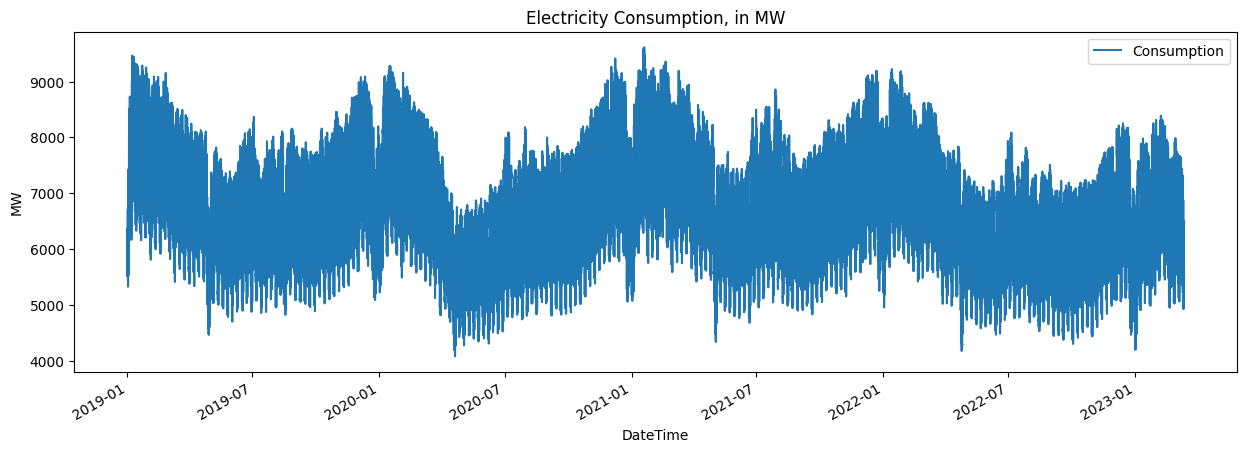

In [6]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

Excelent, we can see that our entire dataste (of 4 and a half years) has a seasonality to it.

Now let us plot just a week, to see if the seasonality checks up.

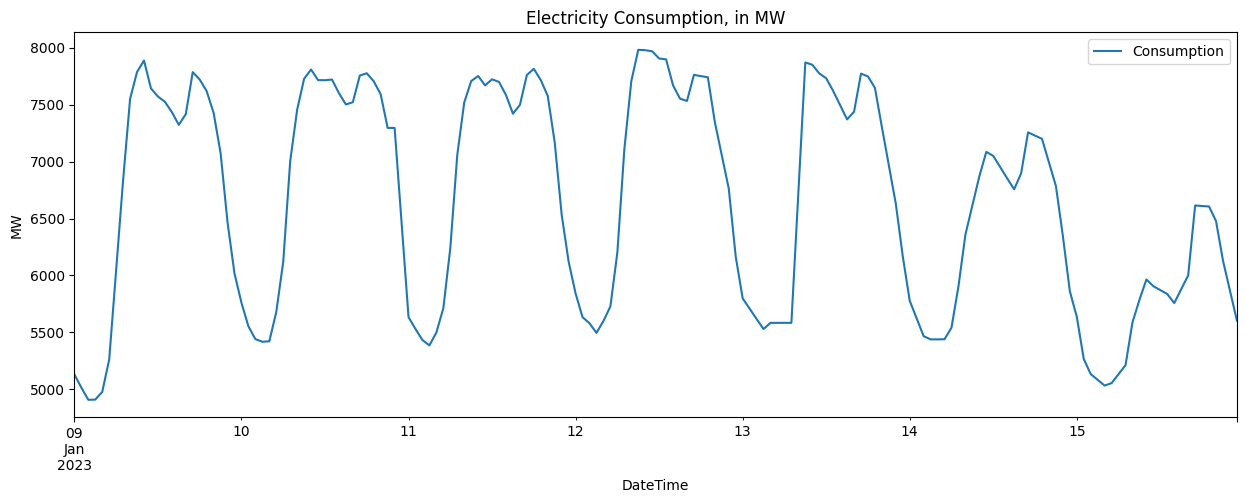

In [7]:
df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

Great, we can see that our data has a very nice seasonality to it also at the week level.

# Add features and split the datain train and test sets

First let as add some new features that are derived hout the DateTime index.

In [8]:
# method for adding time features by the time index
def createTimeFeatures(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear


# apply the method to the existing dataframe
createTimeFeatures(df)

df.head()

,Consumption,hour,day_of_week,quarter,month,year,day_of_year
DateTime,,,,,,,
2019-01-01 00:00:00,6352,0,1,1,1,2019,1
2019-01-01 01:00:00,6116,1,1,1,1,2019,1
2019-01-01 02:00:00,5873,2,1,1,1,2019,1
2019-01-01 03:00:00,5682,3,1,1,1,2019,1
2019-01-01 04:00:00,5557,4,1,1,1,2019,1


Now let us split the data, we will use the last year as our dataset.

Do also a simple plot to see as a graph what is the percentage of the train versus datasets. A red vetical line will represent the split.

cutOffDate 2022-03-13 01:00:00
train size: 28013 and test 8759


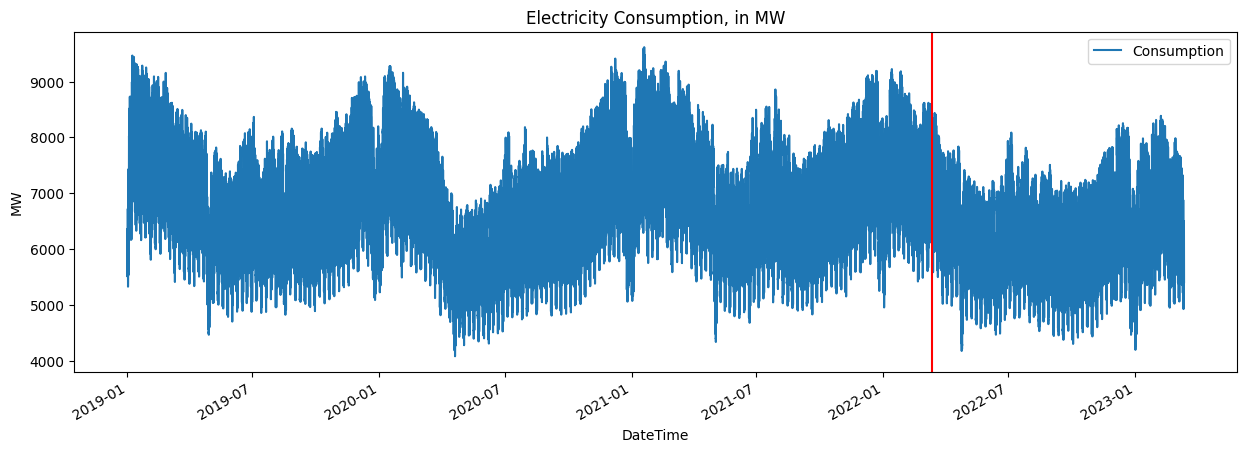

In [9]:
cutOffDate = df.index[-365 * 24]
print(f"cutOffDate {cutOffDate}")

train = df.loc[df.index <= cutOffDate]
test = df.loc[df.index > cutOffDate]

print(f"train size: {len(train)} and test {len(test)}")

df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.axvline(x=cutOffDate, color='r')
plt.show()

Cool, now we have augmented our dataframe with some new features and we have split the dataframe in train and test.

# Create simple method for calculating the error

We want to create a simple method that will show the error betwne the actual value and predicted value as a percentage.

In [10]:
def meanAbsolutErrorAaPercentage(real, predicted):
    real = np.array(real)
    predicted = np.array(predicted)

    return np.mean(np.abs((real - predicted) / real)) * 100

# Forecasting using Regression

Here we will prepare our data in train and test Xs and ys and use a XGB regressor to predict the target feature or our training part of the dataset.

In [11]:
%%time

# define our features and our target as separate arrays
FEATURES = ["hour", "day_of_week", "quarter", "month", "year", "day_of_year"]
TARGET = "Consumption"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# define and XGB regressor, fit it on our train data and use it to predict our test data
regressor = xgb.XGBRegressor(n_estimators=1000, early_stoppin_rounds=50, learning_rate=0.01)

regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
regressorOutput = regressor.predict(X_test)

prediction = pd.DataFrame(data=regressorOutput, index=X_test.index, columns=["prediction"])

df = df.merge(prediction, how="left", left_index=True, right_index=True)

# our predictions are at the end of the dataframe, so we should print that
df.tail()

[0]	validation_0-rmse:1032.79699	validation_1-rmse:1045.39781
[100]	validation_0-rmse:538.51188	validation_1-rmse:735.28616


C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remo

[200]	validation_0-rmse:374.82591	validation_1-rmse:705.28202
[300]	validation_0-rmse:311.97531	validation_1-rmse:705.39659
[400]	validation_0-rmse:271.83271	validation_1-rmse:706.39158
[500]	validation_0-rmse:245.75869	validation_1-rmse:704.59735
[600]	validation_0-rmse:228.38289	validation_1-rmse:711.96299
[700]	validation_0-rmse:216.29585	validation_1-rmse:717.11446
[800]	validation_0-rmse:206.56454	validation_1-rmse:719.41389
[900]	validation_0-rmse:197.41312	validation_1-rmse:718.73906
[999]	validation_0-rmse:190.22871	validation_1-rmse:720.89060
CPU times: total: 17.6 s
Wall time: 1.69 s


C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be remo

,Consumption,hour,day_of_week,quarter,month,year,day_of_year,prediction
DateTime,,,,,,,,
2023-03-12 19:00:00,6500,19,6,1,3,2023,71,7314.051758
2023-03-12 20:00:00,6471,20,6,1,3,2023,71,7323.088867
2023-03-12 21:00:00,6194,21,6,1,3,2023,71,7045.944336
2023-03-12 22:00:00,5708,22,6,1,3,2023,71,6621.527344
2023-03-12 23:00:00,5409,23,6,1,3,2023,71,6319.262695


In [12]:
pickle.dump(regressor, open('elecModel.pkl','wb'))

Let's calculate the error withe method that we defined before.

In [13]:
# select the part of the data frame that is our test part
testDf = df.loc[df.index > cutOffDate]

yReal = testDf["Consumption"]
yPredicted = testDf["prediction"]

print(f"percentage error: {meanAbsolutErrorAaPercentage(yReal, yPredicted):.4f}")

percentage error: 10.2054


Great, so the percentage error between the predicted and actual value is a little over 10%, **10.1803** precisily.

Now let's plot the prediction over the actual data, first for all the dataset and after for just a week.

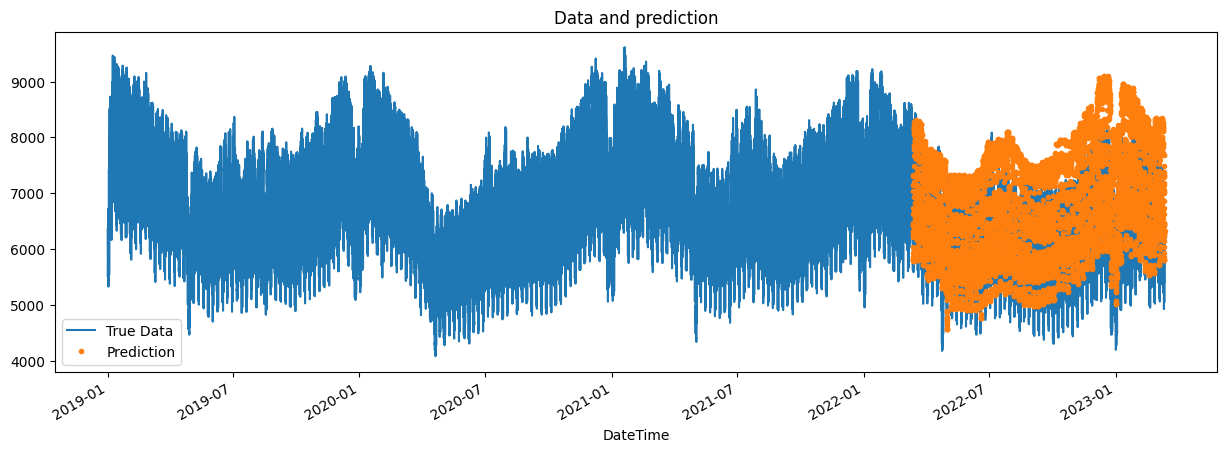

In [14]:
ax = df[[TARGET]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

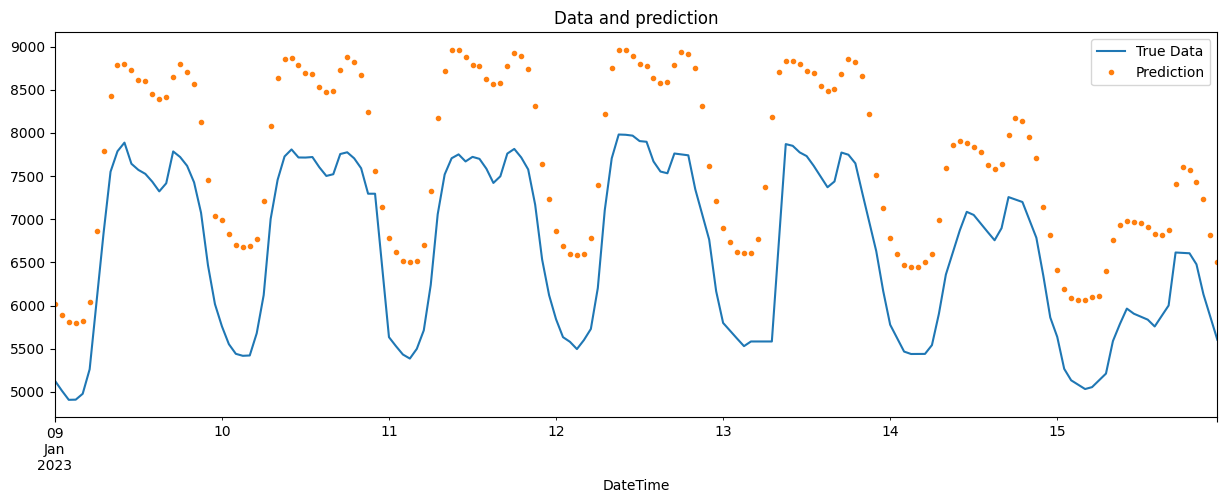

In [15]:
ax = df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][[TARGET]].plot(figsize=(15,5))
df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"]["prediction"].plot(ax=ax, style=".")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

So we plot the data for the entiere time range and also for just a week. The difference of about 10% is clearly visible but the regression model did pick up the pattern very well.

# Forecasting using Prophet

Prophet is a time series prediction library developed by Facebook/Meta. It is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality.

Prophet needs to be imported, as we did at the start of this notebook.

Prophets wan to have the date time column names as **ds**, and the target as **y**. So we will reset our index and rename our columns as needed.

We will do this for both our train and test dataframes.

In [16]:
prophetTrain = train.reset_index()
prophetTrain.drop(FEATURES, axis=1, inplace=True)
prophetTrain.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTrain.tail()

,ds,y
28008,2022-03-12 21:00:00,7458
28009,2022-03-12 22:00:00,6912
28010,2022-03-12 23:00:00,6377
28011,2022-03-13 00:00:00,6119
28012,2022-03-13 01:00:00,5864


In [17]:
prophetTest = test.reset_index()
prophetTest.drop(FEATURES, axis=1, inplace=True)
prophetTest.rename(columns={"DateTime": "ds", "Consumption": "y"}, inplace=True)

prophetTest.tail()

,ds,y
8754,2023-03-12 19:00:00,6500
8755,2023-03-12 20:00:00,6471
8756,2023-03-12 21:00:00,6194
8757,2023-03-12 22:00:00,5708
8758,2023-03-12 23:00:00,5409


Great, now let's create the Prophet object, fit it on the train data and use the test data for predicting.

In [18]:
%%time

prophetModel = Prophet()
prophetModel.fit(prophetTrain)

prophetPrediction = prophetModel.predict(prophetTest)

yRealProphet = test["Consumption"]
yPredictedProphet = prophetPrediction["yhat"]

print(f"prophet percentage error: {meanAbsolutErrorAaPercentage(yRealProphet, yPredictedProphet):.4f}")

19:44:22 - cmdstanpy - INFO - Chain [1] start processing
19:44:30 - cmdstanpy - INFO - Chain [1] done processing


prophet percentage error: 5.5418
CPU times: total: 2.16 s
Wall time: 11.8 s


The Prophet prediction is out of the box at an about 5% error, **5.5591** precisily.

Now let's also plot the predinction for the Prophet prediction. For the entiere data set and then for just a week.

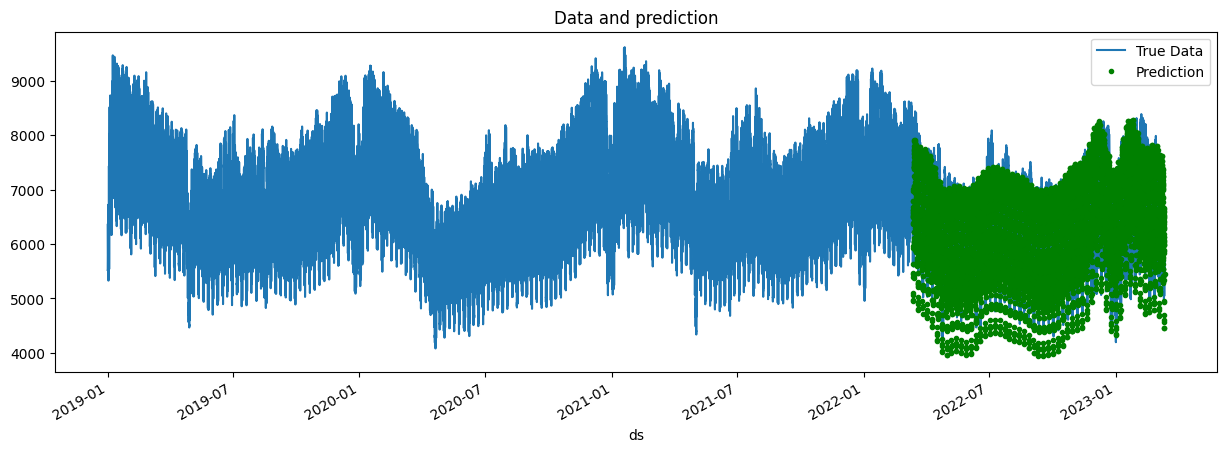

In [19]:
# in order to be optimaly plot the data we set it's ds (our initial DateTime) as the index
prophetPrediction = prophetPrediction.set_index("ds")

ax = df[[TARGET]].plot(figsize=(15,5))
prophetPrediction["yhat"].plot(ax=ax, style=".", color="g")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

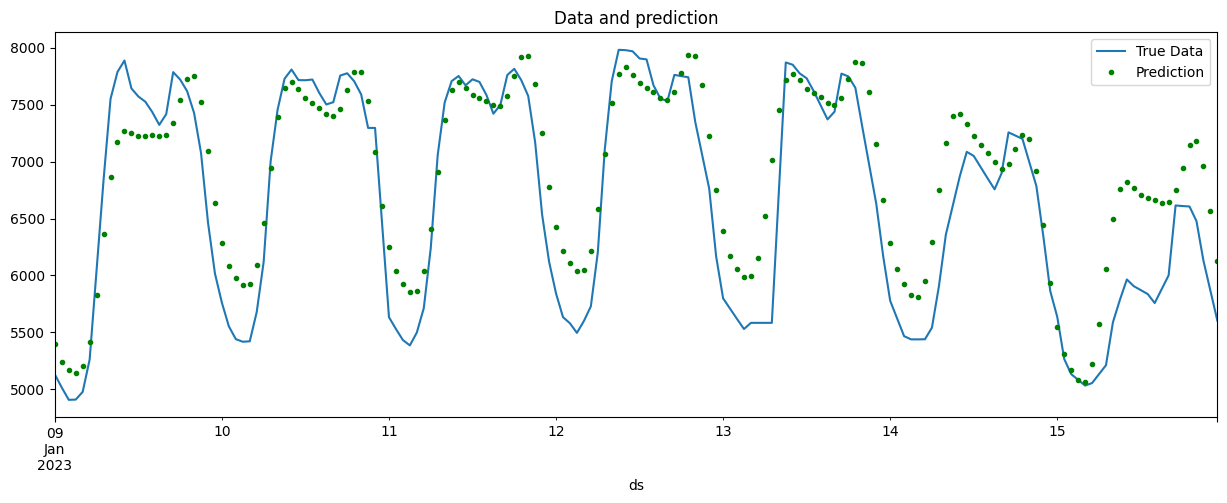

In [20]:
ax = df["2023-01-09 00:00:00" : "2023-01-15 23:59:59"][[TARGET]].plot(figsize=(15,5))
prophetPrediction["2023-01-09 00:00:00" : "2023-01-15 23:59:59"]["yhat"].plot(ax=ax, style=".", color="g")
ax.legend(["True Data", "Prediction"])
ax.set_title("Data and prediction")
plt.show()

So the Prophet prediction looks pretty good, after plotting it's easy to see that the trend is followed pretty well and we get a smaller error.